In [1]:
import numpy as np
import mxnet as mx
import os

from mxnet import autograd, gluon, nd
from mxnet.gluon import nn, rnn, Block
from mxnet.contrib import text
from sklearn import metrics

from io import open
import collections
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PAD = '<PAD>'

In [3]:
epochs = 5
hidden_dim = 400
drop_prob = 0.2
batch_size = 256
learning_rate = 0.01
num_layers = 2
dense_hidden_dim = 300
bidirectional = True

max_seq_len = 30
ctx = mx.gpu()

In [4]:
def read_data(max_seq_len):
    input_tokens = []   # 记录编码器输入 X 的所有词，包含重复
    output_tokens = []  # 记录解码器输出 Y 的所有符号，包含重复
    input_seqs = []  # 列表中装的列表，里面的每个列表代表一条输入，填充或截断好了的
    output_seqs = []  # 同input_seqs
    
    with open("../data_for_seq2seq/re_cut_lines_word.txt", 'r') as fx, open("../data_for_seq2seq/re_cut_lines_label.txt", 'r') as fy:
        word_lines = fx.readlines()
        label_lines = fy.readlines()
        
        for word_line, lable_line in zip(word_lines, label_lines):
            
            input_seq = word_line.strip()
            output_seq = lable_line.strip()
            
            cur_input_tokens = input_seq.split(' ')
            cur_output_tokens = output_seq.split(' ')
            
            if len(cur_input_tokens) < max_seq_len or len(cur_output_tokens) < max_seq_len:
                input_tokens.extend(cur_input_tokens)
                output_tokens.extend(cur_output_tokens)
                
                # 添加 PAD 符号使每个序列等长，长度为 max_seq_len
                while len(cur_input_tokens) < max_seq_len:
                    cur_input_tokens.append(PAD)
                    # 把输出也填充到了最大长度
                    cur_output_tokens.append(PAD)
                    
                input_seqs.append(cur_input_tokens)                            
                output_seqs.append(cur_output_tokens)
                
            else:
                cur_input_tokens = cur_input_tokens[0: max_seq_len]
                cur_output_tokens = cur_output_tokens[0: max_seq_len]
                
                input_tokens.extend(cur_input_tokens)
                input_seqs.append(cur_input_tokens)
                
                output_tokens.extend(cur_output_tokens)
                output_seqs.append(cur_output_tokens)
                
        fr_vocab = text.vocab.Vocabulary(collections.Counter(input_tokens), reserved_tokens=[PAD])
        en_vocab = text.vocab.Vocabulary(collections.Counter(output_tokens), reserved_tokens=[PAD])
    
    return fr_vocab, en_vocab, input_seqs, output_seqs

In [5]:
input_vocab, output_vocab, input_seqs, output_seqs = read_data(max_seq_len)

In [6]:
len(input_vocab)

215541

In [7]:
output_vocab.idx_to_token

['<unk>', '<PAD>', 'N', 'C', 'B', 'E', 'I', '']

In [8]:
# X = nd.zeros((len(input_seqs), max_seq_len))
# Y = nd.zeros((len(output_seqs), max_seq_len))

# for i in range(len(input_seqs)):
#     X[i] = nd.array(input_vocab.to_indices(input_seqs[i]))
#     Y[i] = nd.array(output_vocab.to_indices(output_seqs[i]))
# np.save("../data_for_mul-rnn/X.npy", X.asnumpy())
# np.save("../data_for_mul-rnn/Y.npy", Y.asnumpy())

In [9]:
# Y[0]

In [10]:
if os.path.exists("../data_for_mul-rnn/X.npy") and  os.path.exists("../data_for_mul-rnn/Y.npy"):
    print("Loading...")
    X = np.load("../data_for_mul-rnn/X.npy")
    Y = np.load("../data_for_mul-rnn/Y.npy")
    print("End")
else:
    print("Converting...")
    X = nd.zeros((len(input_seqs), max_seq_len))
    Y = nd.zeros((len(output_seqs), max_seq_len))

    for i in range(len(input_seqs)):
        X[i] = nd.array(input_vocab.to_indices(input_seqs[i]))
        Y[i] = nd.array(output_vocab.to_indices(output_seqs[i]))
    np.save("../data_for_mul-rnn/X.npy", X.asnumpy())
    np.save("../data_for_mul-rnn/Y.npy", Y.asnumpy())
    print("End")

Loading...
End


In [11]:
Y[0].shape

(50,)

In [12]:
X[0].shape

(50,)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=33)
((X_train.shape, Y_train.shape), (X_test.shape, Y_test.shape))

(((386560, 50), (386560, 50)), ((42952, 50), (42952, 50)))

In [14]:
dataset_train = gluon.data.ArrayDataset(nd.array(X_train, ctx=ctx), nd.array(Y_train, ctx=ctx))
data_iter_train = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True, last_batch='rollover')

dataset_test = gluon.data.ArrayDataset(nd.array(X_test, ctx=ctx), nd.array(Y_test, ctx=ctx))
data_iter_test = gluon.data.DataLoader(dataset_test, batch_size, shuffle=True, last_batch='rollover')

In [15]:
del X_train, X_test, Y_train, Y_test

In [16]:
# embedding = text.embedding.create('fasttext', pretrained_file_name='wiki.zh.vec', vocabulary=input_vocab)

In [17]:
# print(len(input_vocab))
# print(len(embedding))
# print(embedding.to_indices([PAD, '中国']))
# print(input_vocab.to_indices([PAD, '中国']))

## 模型定义

In [18]:
class Mul_Layers_Bid_GRU(Block):
    def __init__(self, hidden_dim, input_dim, dense_hidden_dim, output_dim, num_layers, drop_prob):
        super(Mul_Layers_Bid_GRU, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.dense_hidden_dim = dense_hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        
        self.dropout = nn.Dropout(drop_prob)
        self.rnn = rnn.GRU(hidden_dim, num_layers, dropout=drop_prob, bidirectional=True)
        
        self.dense_hidden = nn.Dense(dense_hidden_dim, activation='relu', flatten=False)
        self.out = nn.Dense(output_dim, flatten=False)
        
    def forward(self, inputs, states):
        # states 是一个列表
        # inputs尺寸: (batch_size, num_steps)，emb尺寸: (num_steps, batch_size, 300)
        batch_size = inputs.shape[0]
        num_steps = inputs.shape[1]
        
        emb = self.embedding(inputs).swapaxes(0, 1)
        emb = self.dropout(emb)
        
        # hidden_output 尺寸：(num_steps, batch_size, 2*hidden_dim)
        # state 尺寸: (2*num_layers, batch_size, hidden_dim)      
        hidden_output, bid_state = self.rnn(emb, states[0])
        
        # hidden_output shape: (num_steps, batch_size, 2*hidden_dim)
        # 转变为 （batch_size, num_steps, 2*hidden_dim)
        hidden_output = hidden_output.swapaxes(0, 1)
        hidden_output = self.dropout(hidden_output)
        
        # dense_hidden_output shape: (batch_size, num_steps, dense_hidden_dim)
        dense_hidden_output = self.dense_hidden(hidden_output)
        dense_hidden_output = self.dropout(dense_hidden_output)
               
        # output shape: (batch_size, num_steps, output_dim)
        output = self.out(dense_hidden_output)
        
        return output
    
    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)       

In [19]:
dic_value = nd.array(list(output_vocab.token_to_idx.values()), ctx=ctx)

In [20]:
label_one_hot = nd.one_hot(dic_value, dic_value.shape[0])

In [21]:
label_one_hot


[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
<NDArray 8x8 @gpu(0)>

In [22]:
nd.take(label_one_hot, nd.array([0, 2, 4], ctx=ctx))


[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]
<NDArray 3x8 @gpu(0)>

In [23]:
output_vocab.idx_to_token

['<unk>', '<PAD>', 'N', 'C', 'B', 'E', 'I', '']

In [24]:
def cal_scores(y_hat, label):
    """y_hat 与 label 都为一维向量"""
    p = metrics.precision_score(label, y_hat, average=None)
    r = metrics.recall_score(label, y_hat, average=None)
    f1 = metrics.recall_score(label, y_hat, average=None)
    return p, r, f1

In [25]:
def train(model, max_seq_len, label_one_hot, output_vocab, learning_rate, ctx):
    # 对于三个网络，分别初始化它们的模型参数并定义它们的优化器。
    model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
    
    optimizer = gluon.Trainer(model.collect_params(), 'adam',
                                      {'learning_rate': learning_rate})

    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    prev_time = datetime.datetime.now()
    
    total_loss = []
    total_p = []
    total_r = []
    total_f1 = []
    
    for epoch in range(0, epochs):
        epoch_loss = 0.0
        preds = []
        trues = []
        batch_idx = 0
        for x, y in data_iter_train:
            with autograd.record():
                batch_loss = nd.array([0], ctx=ctx)
                state = model.begin_state(
                    func=mx.nd.zeros, batch_size=batch_size, ctx=ctx)
                
                # outputs shape: (batch_size, num_step, output_dim)
                outputs = model(x, state)
                # label shape: (batch_size, num_step, output_dim)
                label = nd.take(label_one_hot, y)
                batch_loss = nd.mean(softmax_cross_entropy(outputs, label))
                
            batch_loss.backward()
            optimizer.step(batch_size)
            
            epoch_loss += batch_loss.asscalar()       
            
            # pred_outputs shape: (batch_size, num_step)
            pred_outputs = nd.argmax(nd.softmax(outputs, axis=2), axis=2)    
            
            preds.append(pred_outputs)
            trues.append(y)
            
            # print(pred_outputs.shape)           
            
            if batch_idx % 500 == 0:
#                 batch_p, batch_r, batch_f1 = cal_scores(pred_outputs.reshape((-1,)).asnumpy(), y.reshape((-1,)).asnumpy())
                print("epoch: {0} , batch: {1}, batch_loss: {2}".format(epoch, batch_idx, batch_loss.asscalar()))
#                 print("batch_p: {0}".format(batch_p))
#                 print("batch_r: {0}".format(batch_r))
#                 print("batch_f1: {0}".format(batch_f1))
                for idx in range(2): 
                    true_idx = [int(x) for x in list(y[idx].asnumpy())]
                    pred_idx = [int(x) for x in list(pred_outputs[idx].asnumpy())]
                    
                    true_label = output_vocab.to_tokens(true_idx)
                    pred_label = output_vocab.to_tokens(pred_idx)
                    
                    print("Sapmle {0} :".format(idx))
                    print("True label : {0}".format(true_label))
                    print("Pred label : {0}".format(pred_label))
            batch_idx += 1
            
        
        epoch_loss = epoch_loss / batch_idx
        
        cal_score_pred = nd.concat(*preds, dim=0).reshape((-1,)).asnumpy()
        cal_score_true = nd.concat(*trues, dim=0).reshape((-1,)).asnumpy()
        
        epoch_p, epoch_r, epoch_f1 = cal_scores(cal_score_pred, cal_score_true)
        
        total_loss.append(epoch_loss)
        total_p.append(epoch_p)
        total_r.append(epoch_r)
        total_f1.append(epoch_f1)
        
        print("epoch: {0} , epoch_loss: {1}".format(epoch, epoch_loss))
        print("epoch_p: {0}".format(epoch_p))
        print("epoch_r: {0}".format(epoch_r))
        print("epoch_f1: {0}".format(epoch_f1))
        print("-----------------------------------------------------")
    
    plt.plot(range(epochs), total_loss)
    plt.show()
    
            

In [26]:
model = Mul_Layers_Bid_GRU(hidden_dim, len(input_vocab), dense_hidden_dim, len(output_vocab), num_layers, drop_prob)

epoch: 0 , batch: 0, batch_loss: 2.0801637172698975
Sapmle 0 :
True label : ['C', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Pred label : ['', '<unk>', '', '', '<unk>', '<unk>', '', '', 'I', '<unk>', '', '', 'E', '<PAD>', '<unk>', '', '', '', 'N', 'N', '', 'I', '', '<PAD>', '<unk>', '', '', '', '', '', 'C', '', '<unk>', '', '', '', 'E', 'E', '', '<unk>', '', 'E', 'I', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'N', 'E']
Sapmle 1 :
True label : ['C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Pred label : ['', '<u

c:\developtool\python\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


epoch: 0 , epoch_loss: 0.4229380942535716
epoch_p: [0.         0.99541995 0.8377669  0.52707297 0.23717097 0.12206409
 0.03227771 0.        ]
epoch_r: [0.00000000e+00 9.95905007e-01 9.89373188e-01 2.47643383e-01
 4.00598802e-03 2.15136499e-03 3.05148371e-04 0.00000000e+00]
epoch_f1: [0.00000000e+00 9.95905007e-01 9.89373188e-01 2.47643383e-01
 4.00598802e-03 2.15136499e-03 3.05148371e-04 0.00000000e+00]
-----------------------------------------------------
epoch: 1 , batch: 0, batch_loss: 0.3241179585456848
Sapmle 0 :
True label : ['N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Pred label : ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

epoch: 2 , batch: 1000, batch_loss: 0.1683739721775055
Sapmle 0 :
True label : ['N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'C', 'N', 'E', 'B', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Pred label : ['N', 'C', 'E', 'N', 'N', 'N', 'C', 'N', 'B', 'E', 'N', 'N', 'N', 'C', 'N', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
Sapmle 1 :
True label : ['N', 'N', 'N', 'N', 'C', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'N', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Pred label : ['N', 'N', 'N', 'N', 'C', 'N', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'B', 'E'

epoch: 3 , epoch_loss: 0.17291794000871924
epoch_p: [0.9999776  0.93030695 0.86656917 0.69776518 0.71152027 0.64171744
 0.75      ]
epoch_r: [0.99997774 0.97598269 0.92017757 0.4365524  0.47105506 0.38809115
 0.69230769]
epoch_f1: [0.99997774 0.97598269 0.92017757 0.4365524  0.47105506 0.38809115
 0.69230769]
-----------------------------------------------------
epoch: 4 , batch: 0, batch_loss: 0.1607147455215454
Sapmle 0 :
True label : ['C', 'B', 'I', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'B', 'E', 'C', 'N', 'N', 'C', 'C', 'N', 'N', 'N', 'N', 'N', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'B', 'E', '<PAD>', '<PAD>']
Pred label : ['C', 'C', 'B', 'E', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'B', 'E', 'C', 'N', 'N', 'C', 'C', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'C', 'N', 'N', 'N', 'N', 'N', '<PAD>', '<PAD>']
Sapmle 1 :
True label : ['N'

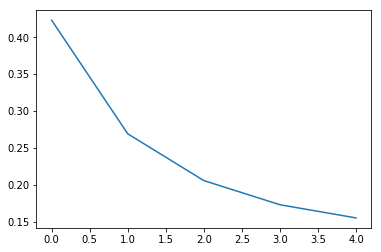

In [27]:
train(model, max_seq_len, label_one_hot, output_vocab, learning_rate, ctx)

In [28]:
np.zeros(shape=(1,))

array([0.])

In [29]:
def cal_scores(y_hat, label):
    """y_hat 与 label 都为一维向量"""
    p = metrics.precision_score(label, y_hat, average=None)
    r = metrics.recall_score(label, y_hat, average=None)
    f1 = metrics.recall_score(label, y_hat, average=None)
    return p, r, f1

In [30]:
a = np.array([[1, 0, 1, 0, 0],
              [1, 2, 0, 1, 0]
             ])
b = np.array([[1, 0, 1, 1, 0],
              [1, 1, 1, 0, 1]
             ])

In [31]:
cal_scores(a.reshape(-1), b.reshape(-1))

c:\developtool\python\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(array([0.4 , 0.75, 0.  ]),
 array([0.66666667, 0.42857143, 0.        ]),
 array([0.66666667, 0.42857143, 0.        ]))